# Parameter Efficient Finetune (PEFT)

# What is the problem with training LLMs and finetune them? - Big weights
1. A lot more computation resources to train.
2. The file sizes becomes huge. T5-XXL model - 40GB in size.

Considering a compuatation environment that with only one GPU, then the parallelism methods is not available, including the data parallelism, model parallelism and pipeline parallelism.

Solution - PEFT!

PEFT is consists of variety of different techniques. The one we'are gonna be looking at today is LoRA, which stands for low rank adaption.

PEFT also includes many other techniques such as


*   Prefix Tuning
*   P-Tuning
*   Prompt Tuning
*   etc.




# LoRA
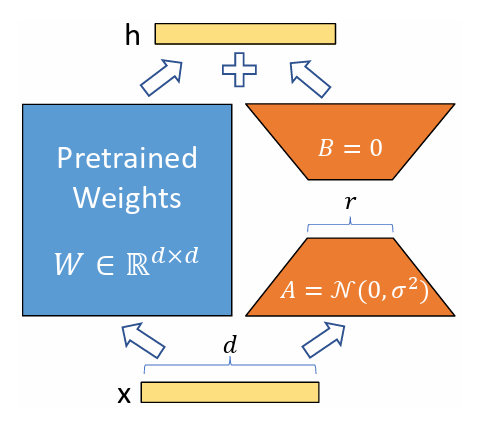

Core idea: Finetune a number of extra parameters in a frozen large model
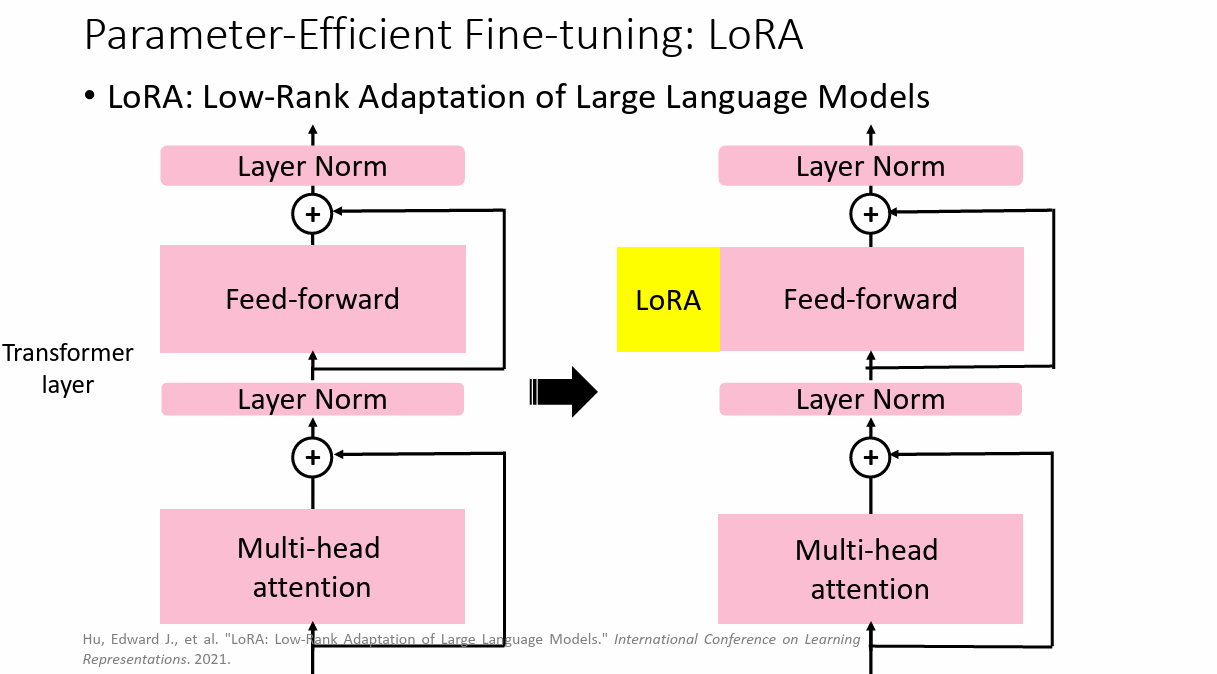

Advantages of lora:
1. No extra inference latency. (By merging the LoRA into the model)
2. No need to worry about the catestrophic forgetting. (By removing the LoRA from the model)
3. LoRA can be combined with some specific techniques to enpower the LLM with different capability efficiently.

# Using 🤗 PEFT & bitsandbytes to finetune a LoRA checkpoint




In [ ]:
!pip install -q bitsandbytes datasets accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git
!pip install trl==0.12.2

In [ ]:
!nvidia-smi

### Setup the model

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig


model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")

tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

### Setting up the LoRa Adapters

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model)

In [ ]:
print(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16, #rank of the lora
    lora_alpha=32, #alpha scaling
    target_modules=["k_proj", "v_proj", "q_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM" # set this for CLM or Seq2Seq
)

lora_equipped_model = get_peft_model(model, config)
print_trainable_parameters(lora_equipped_model)

## Data

In [ ]:
import transformers
from datasets import load_dataset
data = load_dataset("Abirate/english_quotes")


In [ ]:
data['train'][0]

In [ ]:
def merge_columns(example):
    example["prediction"] = example["quote"] + " ->: " + str(example["tags"])
    return example

data['train'] = data['train'].map(merge_columns)
data['train']["prediction"][:5]

In [ ]:
data['train'][0]

In [ ]:
data = data.map(lambda samples: tokenizer(samples['prediction']), batched=True)

In [ ]:
data

### Training

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=data['train'],
    peft_config=config,
    dataset_text_field="prediction",
    max_seq_length=512,
    tokenizer=tokenizer,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=4,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        max_steps=200,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir='outputs',
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

## Inference

In [ ]:
batch = tokenizer("“Training models with PEFT and LoRa is cool” ->: ", return_tensors='pt').to("cuda")

with torch.cuda.amp.autocast():
  output_tokens = model.generate(**batch, max_new_tokens=50)

print('\n\n', tokenizer.decode(output_tokens[0], skip_special_tokens=True))

## Load adapters from the Hub

In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "alvanlii/whisper-largev2-cantonese-peft-lora" #some specific peft id on the peft hub
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_8bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

# Practice

Train a Lora model on the top of "bigscience/bloom-7b1", which is 7B LLM released by bigscience.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM
from datasets import load_dataset
from trl import SFTTrainer
from peft import LoraConfig


model = AutoModelForCausalLM.from_pretrained("bigscience/bloom-7b1")

tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")

# your code here